<a href="https://colab.research.google.com/github/AkashKV-1998/Detection-and-localization-of-CMFD/blob/main/CMFD_Implementated_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting-up environment:

## Install opencv contrib library for SIFT feature detector:

In [13]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_contrib_python-3.4.2.17-cp37-cp37m-manylinux1_x86_64.whl (30.6 MB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 3.4.2.17
    Uninstalling opencv-contrib-python-3.4.2.17:
      Successfully uninstalled opencv-contrib-python-3.4.2.17
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
imgaug 0.2.9 requires opencv-python, which is not ins

## Import all libraries 

In [16]:
from ClusterCall import DBSCAN_Cluster, KMeans_Cluster
from HuThresholdDistribution import Get_Hu_distributions
from SimilarityMeasure import DistanceCalculation
from Metrics import GenerateCM
from Confidence import Confidence_Intervel
import BlockBuilder
from Approximate_Region import Region_Distance
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
from skimage import measure
import os
from datetime import datetime

# Get image and localize forgery if any

##Get test image along with its true binary image for metric calculation

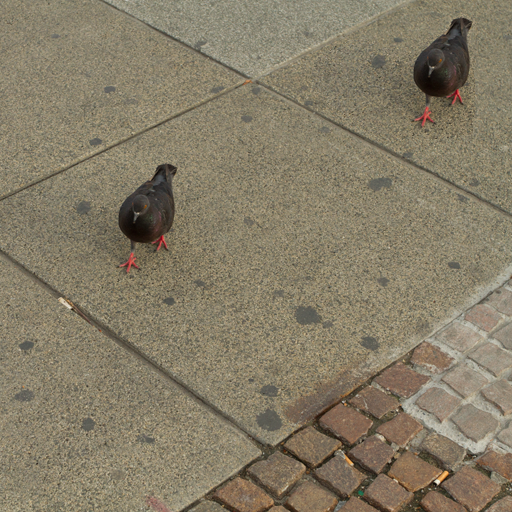

In [17]:
input = './Inputs/015_F.png'
RealBinary = './Inputs/015_B.png'

cv2_imshow(cv2.imread(input))

## Start detecting and localizing forgery regions:

Length of Keypoints from SIFT feature extractor: 1370 and length of descriptors 1370

Delta (minimum distance between pair of blocks) set to : None
Gamma (Sort and take minimum distance ranging from 0 to gamma in every cluster) set to : 20

Detected regions after HuMoments similarity test: 




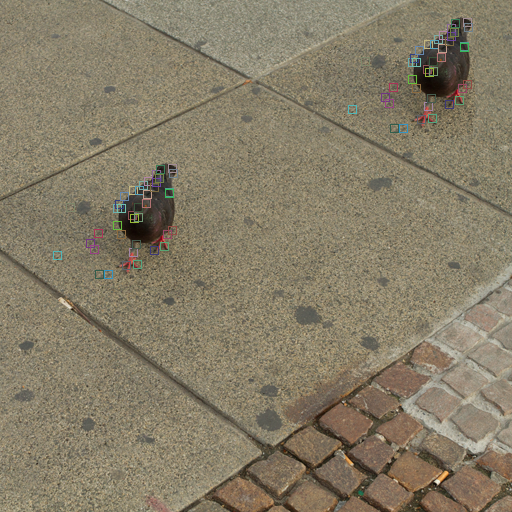

Cluster completed...: 100%|██████████| 131/131 [00:00<00:00, 984.71it/s]


Number of blocks:  2254

Result of CMF after applying region growing: 



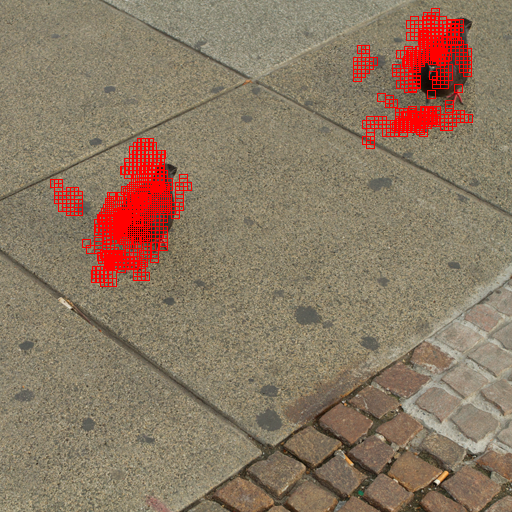


Binary result of CMF after applying region growing: 



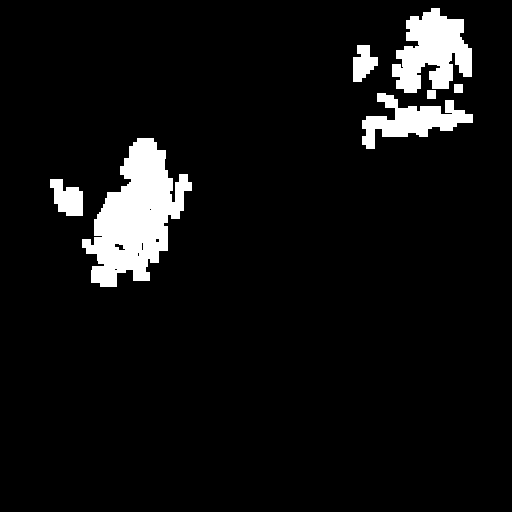


Result: Forgery detected in given image

Confidence of CMF localization: 

Lower Bound: 6.888 
Upper Bound: 10.148


Precision:  0.8251269595937293
Accuracy:  0.9162444444444444
True Positive Rate(TPR):  0.35648192311361254
False Positive Rate(TPR):  0.00996013431090207
F1 Score:  0.49786837196909145

Confusion metric: 

+--------------------+--------------------+-------------------+
|                    | Actual_CMF_Regions | False_CMF_Regions |
+--------------------+--------------------+-------------------+
| Actual_CMF_Regions |        3737        |        792        |
| False_CMF_Regions  |        6746        |       78725       |
+--------------------+--------------------+-------------------+


Comparison between orginal and predicted binary image: 



<Figure size 2880x2880 with 0 Axes>

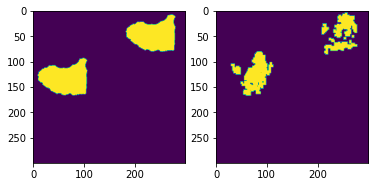

In [18]:
img = cv2.imread(input)
input_size = (512, 512)
BlockSize  = 4
delta1=3.2
delta2=100
gamma=20

img = cv2.resize(img, input_size)
Testimage = img.copy()

# start_time = datetime.now()

# cluster_list = KMeans_Cluster(img, n_clusters=3) 
cluster_list = DBSCAN_Cluster(Testimage, eps=60, min_samples=2)

Block = BlockBuilder.BlockBuilding(Testimage, cluster_list, BlockSize=BlockSize)
img_clusters, blocks = Block.CreateBlocks()
# Block.visualize()

CalculateDis = DistanceCalculation(Testimage, blocks, img_clusters, delta=None, gamma=gamma)
ForgeryRegions = CalculateDis.Calculate(method='HuMoments')
# ForgeryRegions = CalculateDis.Calculate(method='Hu_Adapthreshold', distribution=distribution)
path = '/content/drive/MyDrive/M.Tech FYP/FYP_code/Outputs/HuMoments_initial_blocks_Bny.jpg'
# Detection_Result = Region_Distance(img, path=path, delta=delta2)

# if Detection_Result == 'Y':
image = img.copy()
RegionsGrow = BlockBuilder.RegionGrowing(image, ForgeryRegions, delta=delta1, BlockSize=BlockSize)
Forgery_blocks, Forgery_distance = RegionsGrow.Grow(method='HuMoments')
# Size, Total_blocks = RegionsGrow.Grow(method='Hu_Adapthreshold', distribution=distribution)
RegionsGrow.ShowForgery()

lower_bound, upper_bound = Confidence_Intervel(Forgery_distance)

CodeOut = f'{os.getcwd()}/Outputs//CMF_Binary_Result.jpg'
GenerateCM(CodeOut, RealBinary, ['accuracy', 'precision', 'F1', 'TPR', 'FPR'])

# end_time = datetime.now()
# print('Computation time taken for algorithm: {}\n'.format(end_time - start_time))

## Approximated detected area

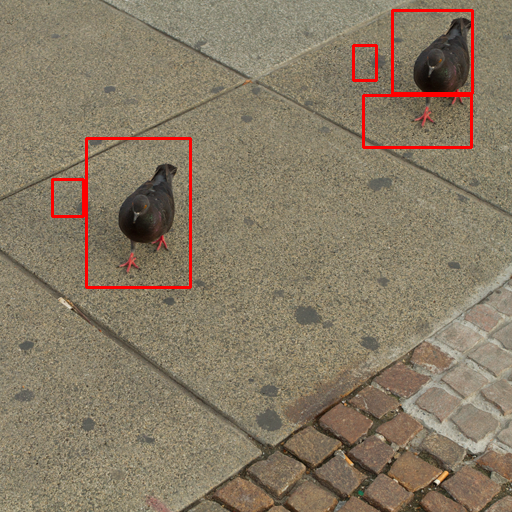

In [19]:
import imutils
from imutils import contours
from skimage import measure

detected_rgns = cv2.imread('./Outputs/CMF_Binary_Result.jpg')
detected_rgns = cv2.cvtColor(detected_rgns, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(detected_rgns, (15, 15), 0)
thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]

thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=4)

labels = measure.label(thresh, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")
# loop over the unique components
for label in np.unique(labels):
	# if this is the background label, ignore it
	if label == 0:
		continue
	# otherwise, construct the label mask and count the
	# number of pixels 
	labelMask = np.zeros(thresh.shape, dtype="uint8")
	labelMask[labels == label] = 255
	numPixels = cv2.countNonZero(labelMask)
	# if the number of pixels in the component is sufficiently
	# large, then add it to our mask of "large blobs"
	if numPixels > 300:
		mask = cv2.add(mask, labelMask)
	
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
if len(cnts) != 0:
	cnts = contours.sort_contours(cnts)[0]
# loop over the contours

forgery_area = []
for (i, c) in enumerate(cnts):
	# draw the bright spot on the image
	(x, y, w, h) = cv2.boundingRect(c)
	cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
	location = img[y:y+h, x:x+w]
	forgery_area.append(location)

# show the output image
cv2_imshow(img)

____